In [63]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import math

In [64]:

train_x_slide = torch.load('./Downloads/train_x_slide.pt')
train_y_slide = torch.load('./Downloads/train_y_slide.pt')
train_y_gan = torch.load('./Downloads/train_y_gan.pt')
test_x_slide = torch.load('./Downloads/test_x_slide.pt')
test_y_slide = torch.load('./Downloads/test_y_slide.pt')
test_y_gan = torch.load('./Downloads/test_y_gan.pt')
validation_x_slide = torch.load('./Downloads/validation_x_slide.pt')
validation_y_slide = torch.load('./Downloads/validation_y_slide.pt')
validation_y_gan = torch.load('./Downloads/validation_y_gan.pt')


print(f'validation_x_slide: {validation_x_slide.shape}')
print(f'validation_y_slide: {validation_y_slide.shape}')
print(f'validation_y_gan: {validation_y_gan.shape}')
print(f'train_x_slide: {train_x_slide.shape}')
print(f'train_y_slide: {train_y_slide.shape}')
print(f'train_y_gan: {train_y_gan.shape}')
print(f'test_x_slide: {test_x_slide.shape}')
print(f'test_y_slide: {test_y_slide.shape}')
print(f'test_y_gan: {test_y_gan.shape}')


validation_x_slide: torch.Size([397, 3, 35])
validation_y_slide: torch.Size([397, 1])
validation_y_gan: torch.Size([397, 4, 1])
train_x_slide: torch.Size([1862, 3, 35])
train_y_slide: torch.Size([1862, 1])
train_y_gan: torch.Size([1862, 4, 1])
test_x_slide: torch.Size([397, 3, 35])
test_y_slide: torch.Size([397, 1])
test_y_gan: torch.Size([397, 4, 1])


In [65]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.lstm_1 = nn.LSTM(input_size, 1024, batch_first=True)
        self.lstm_2 = nn.LSTM(1024, 512, batch_first=True)
        self.lstm_3 = nn.LSTM(512, 256, batch_first=True)
        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        use_cuda = 1
        device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
        h0 = torch.zeros(1, x.size(0), 1024).to(device)
        c0 = torch.zeros(1, x.size(0), 1024).to(device)
        out_1, _ = self.lstm_1(x, (h0, c0))
        out_1 = self.dropout(out_1)
        h1 = torch.zeros(1, x.size(0), 512).to(device)
        c1 = torch.zeros(1, x.size(0), 512).to(device)
        out_2, _ = self.lstm_2(out_1, (h1, c1))
        out_2 = self.dropout(out_2)
        h2 = torch.zeros(1, x.size(0), 256).to(device)
        c2 = torch.zeros(1, x.size(0), 256).to(device)
        out_3, _ = self.lstm_3(out_2, (h2, c2))
        out_3 = self.dropout(out_3)
        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out = self.linear_3(out_5)
        return out

In [66]:
class LSTMTraining:
    def __init__(self, input_size, batch_size, learning_rate, num_epochs, use_cuda=True):
        self.device = torch.device("cuda" if torch.cuda.is_available() and use_cuda else "cpu")
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs

        self.model = Generator(input_size).to(self.device)
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def train(self, train_x, train_y):
        trainDataloader = DataLoader(TensorDataset(train_x, train_y), batch_size=self.batch_size, shuffle=False)
        hist = np.zeros(self.num_epochs)

        for epoch in range(self.num_epochs):
            loss_accumulated = []
            for x, y in trainDataloader:
                x, y = x.to(self.device), y.to(self.device)
                self.optimizer.zero_grad()
                y_pred = self.model(x)
                loss = self.criterion(y_pred, y)
                loss.backward()
                self.optimizer.step()
                loss_accumulated.append(loss.item())

            hist[epoch] = np.sum(loss_accumulated)
            print(f'[{epoch + 1}/{self.num_epochs}] Loss: {hist[epoch]}')

        return hist

In [ ]:
input_size =35
batch_size= 128
learning_rate = 0.000164
num_epochs =100
lstm_trainer = LSTMTraining(input_size, batch_size, learning_rate, num_epochs)
history = lstm_trainer.train(train_x_slide, train_y_slide)

Text(0.5, 0, 'Epochs')

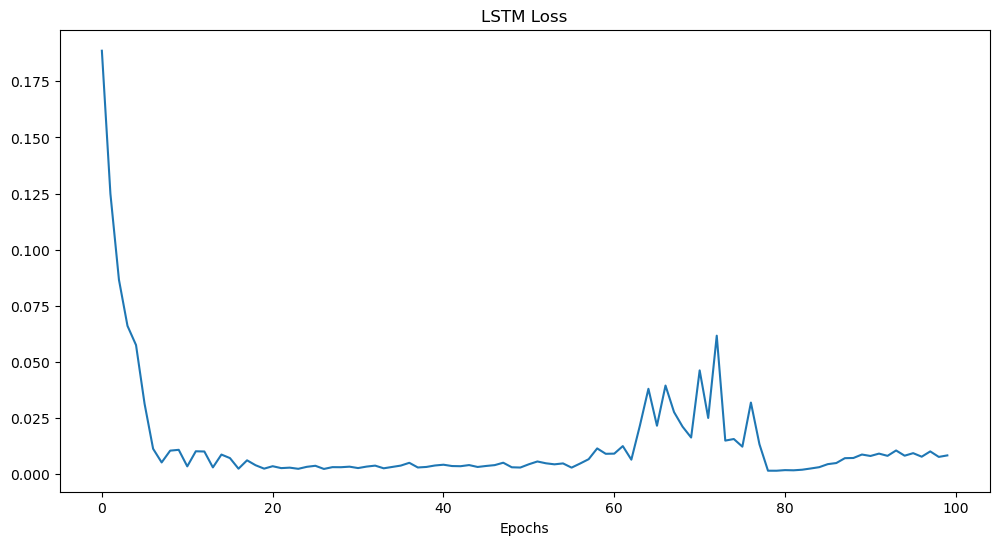

In [ ]:
plt.figure(figsize = (12, 6))
plt.plot(history, label = 'Loss')
plt.title('LSTM Loss')
plt.xlabel('Epochs')

In [ ]:
lstm_trainer.model.eval()
pred_y_train = lstm_trainer.model(train_x_slide)
pred_y_test = lstm_trainer.model(test_x_slide)

y_train = train_y_slide
y_test = test_y_slide

In [ ]:
import pickle

# Load the saved scaler
y_scaler = pickle.load(open('./Downloads/target_scaler.pkl', 'rb'))

# Use the loaded scaler to inverse transform the data
rescaled_y_train = y_scaler.inverse_transform(y_train)
rescaled_y_test = y_scaler.inverse_transform(y_test)


rescaled_pred_y_train = y_scaler.inverse_transform(pred_y_train.detach().numpy())
rescaled_pred_y_test = y_scaler.inverse_transform(pred_y_test.detach().numpy())



/opt/anaconda3/lib/python3.10/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Training dataset RMSE:2.5176036117129827


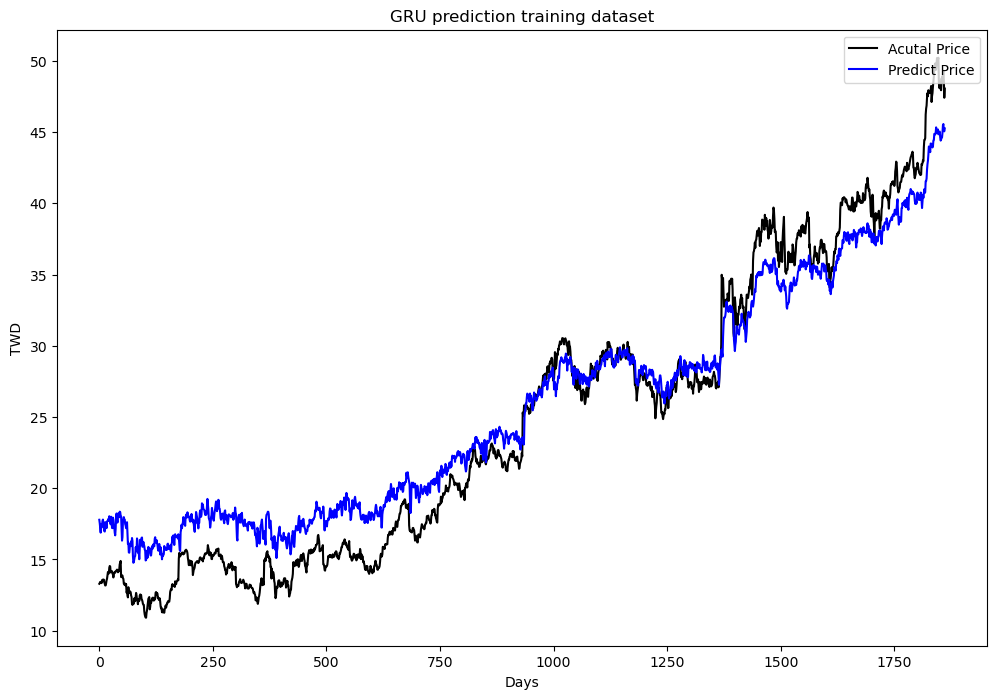

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(rescaled_y_train, color = 'black', label = 'Acutal Price')
plt.plot(rescaled_pred_y_train, color = 'blue', label = 'Predict Price')
plt.title('LSTM prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(rescaled_y_train, rescaled_pred_y_train)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:7.828470512101958


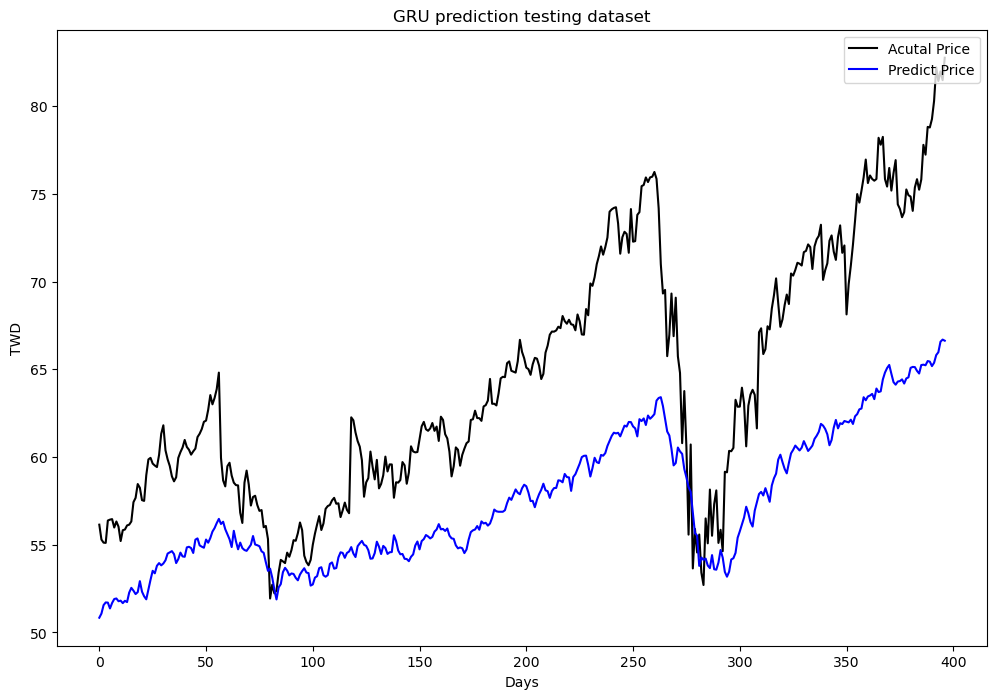

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(rescaled_y_test, color = 'black', label = 'Acutal Price')
plt.plot(rescaled_pred_y_test, color = 'blue', label = 'Predict Price')
plt.title('LSTM prediction testing dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(rescaled_y_test, rescaled_pred_y_test)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

##Hyperparameter Tuning


In [ ]:

type(np.random.choice(learning_rate_options))

numpy.float64

num trial: 0, batch_size: 256, learning_rate: 0.0001, num_epochs: 50
[1/50] Loss: 0.11096272303257138
[2/50] Loss: 0.06034752813866362
[3/50] Loss: 0.044223953038454056
[4/50] Loss: 0.048242685064906254
[5/50] Loss: 0.051542822388000786
[6/50] Loss: 0.04962986664031632
[7/50] Loss: 0.045803327186149545
[8/50] Loss: 0.04035720723186387
[9/50] Loss: 0.03463941454538144
[10/50] Loss: 0.02859972999431193
[11/50] Loss: 0.022952516126679257
[12/50] Loss: 0.015806386567419395
[13/50] Loss: 0.009067636245163158
[14/50] Loss: 0.004135568902711384
[15/50] Loss: 0.0019116627154289745
[16/50] Loss: 0.0016241427292698063
[17/50] Loss: 0.0016015523942769505
[18/50] Loss: 0.00155644140613731
[19/50] Loss: 0.002009238764003385
[20/50] Loss: 0.0019399774355406407
[21/50] Loss: 0.0030511495351674967
[22/50] Loss: 0.0027355680940672755
[23/50] Loss: 0.0041051147563848644
[24/50] Loss: 0.002519994490285171
[25/50] Loss: 0.0026911257045867387
[26/50] Loss: 0.001480514278227929
[27/50] Loss: 0.0014043418159

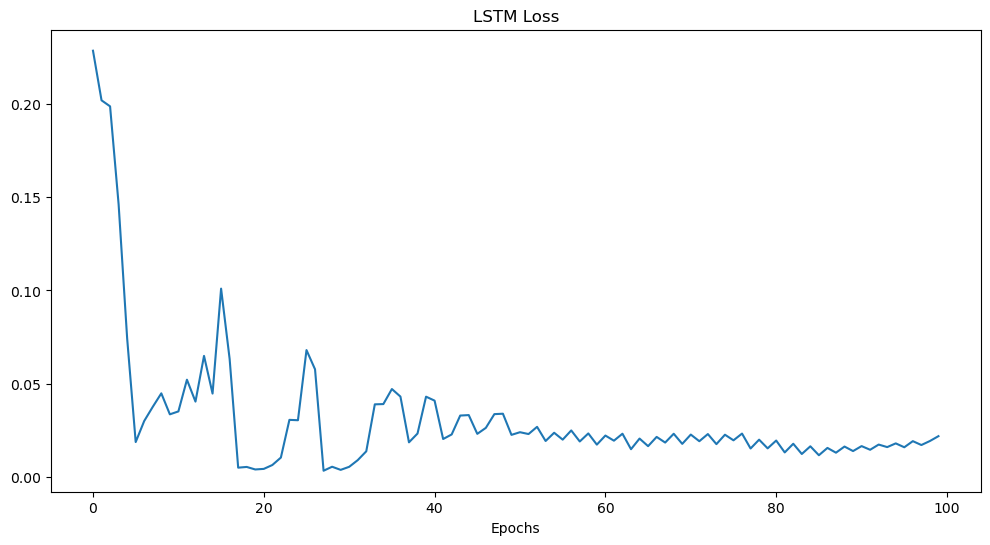

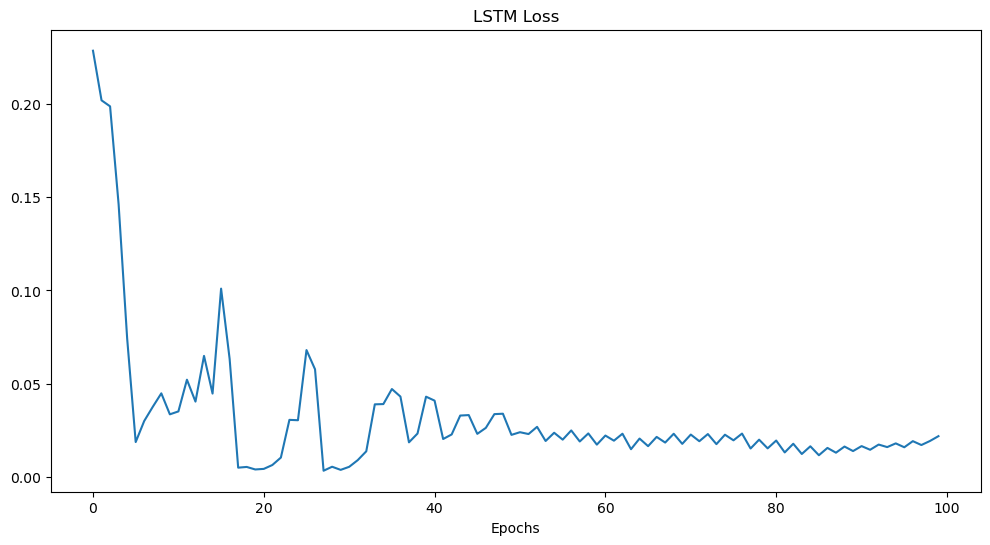

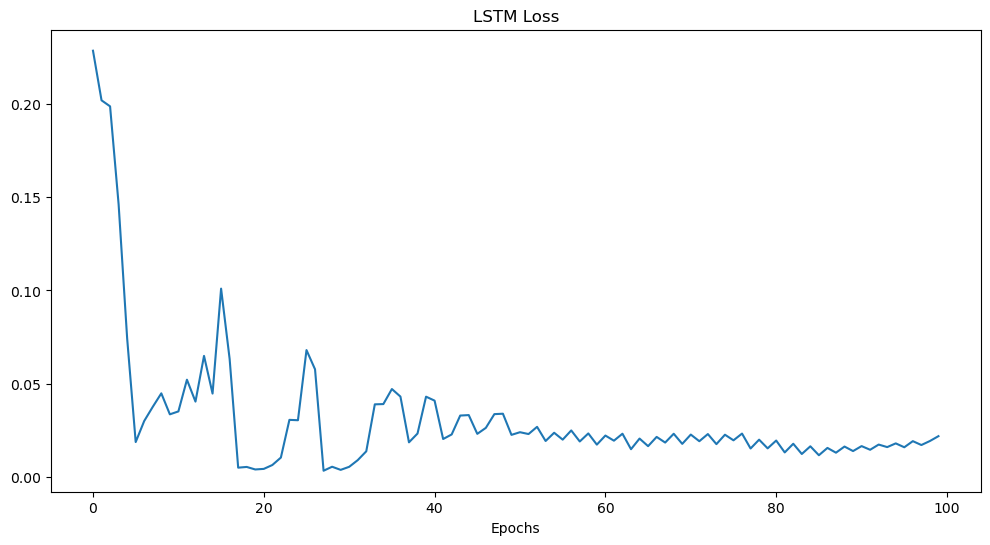

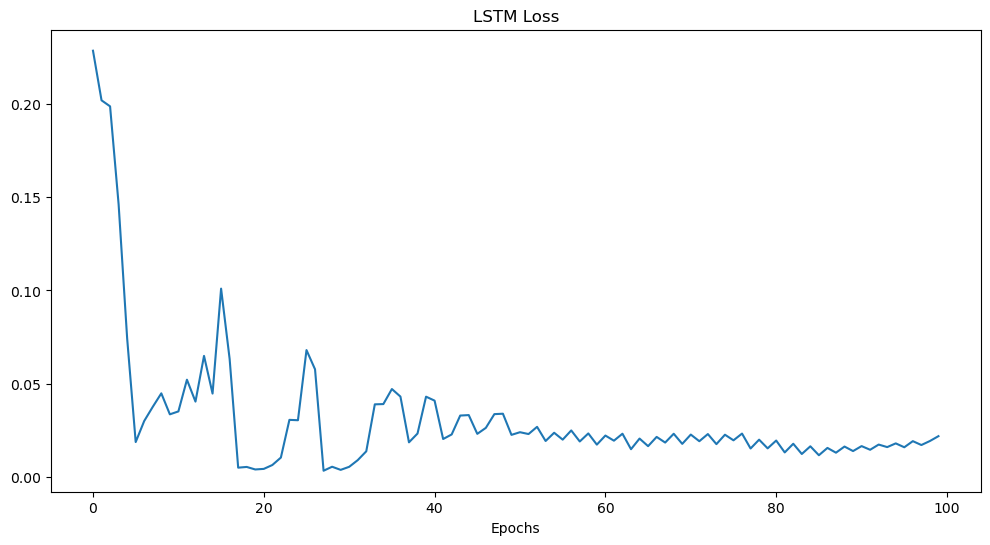

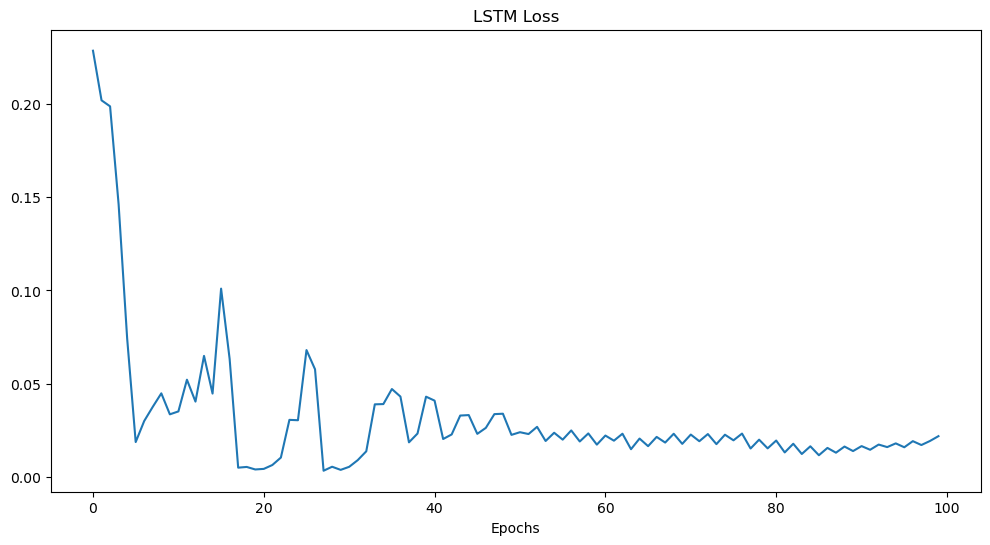

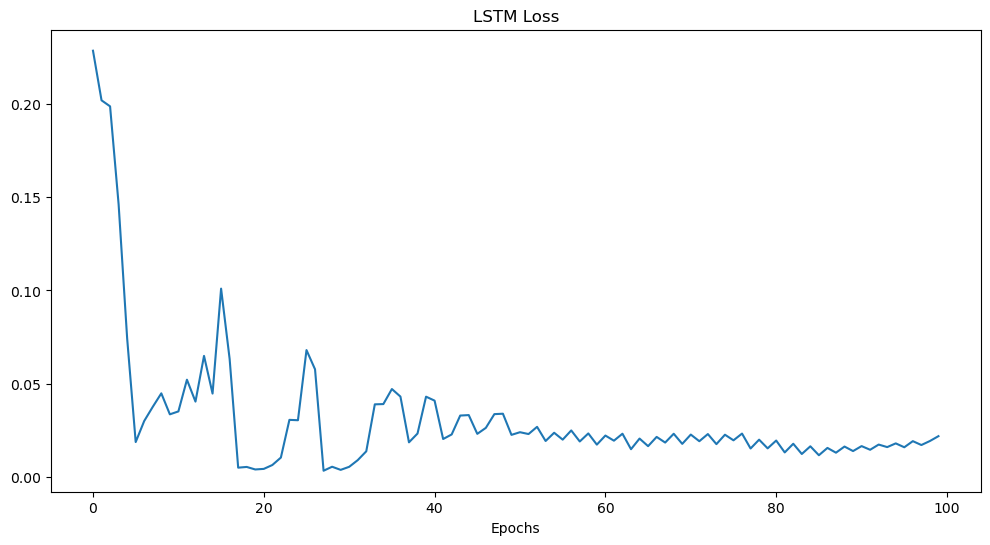

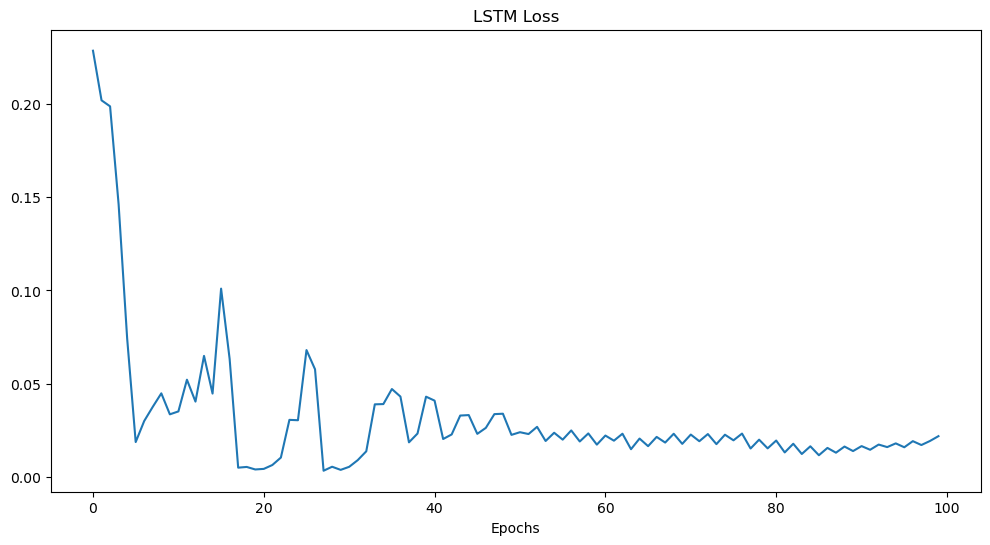

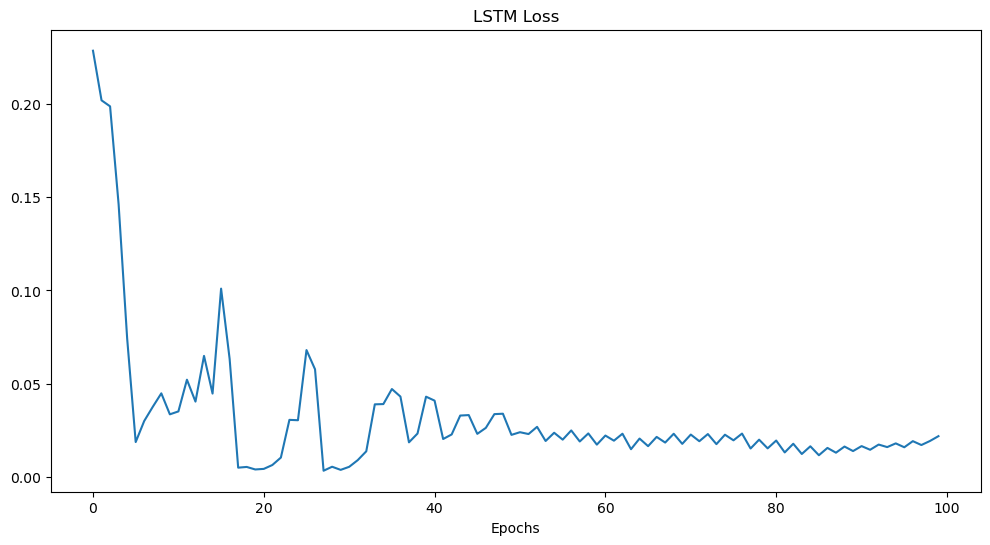

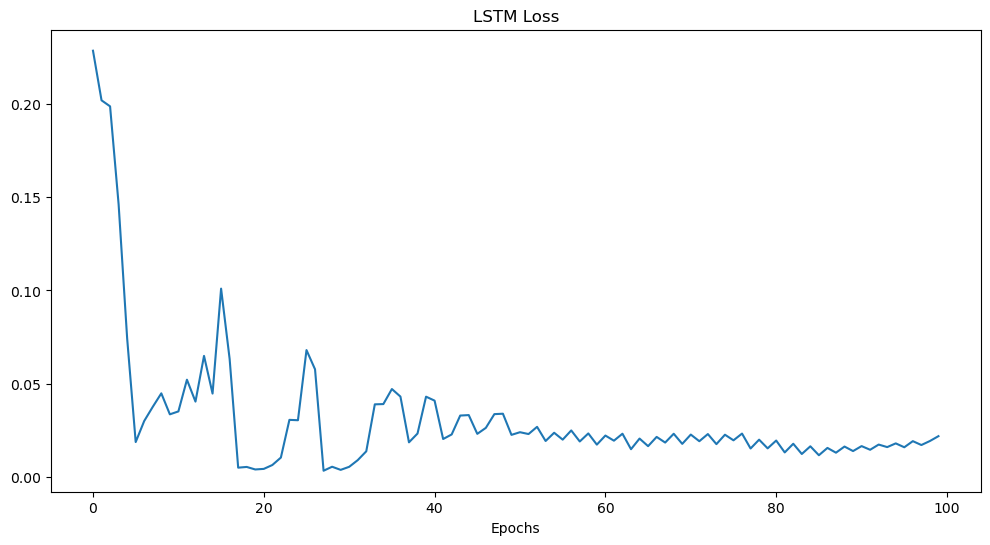

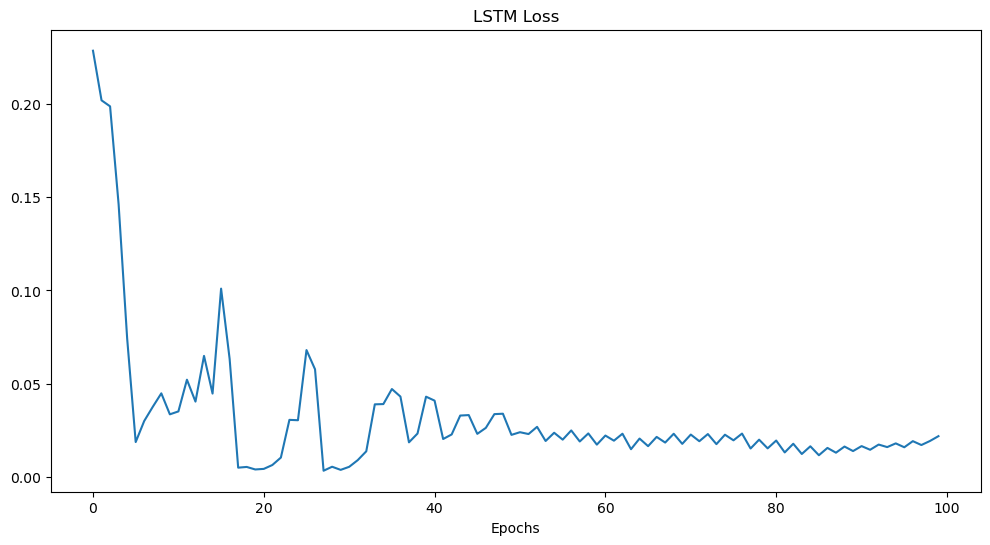

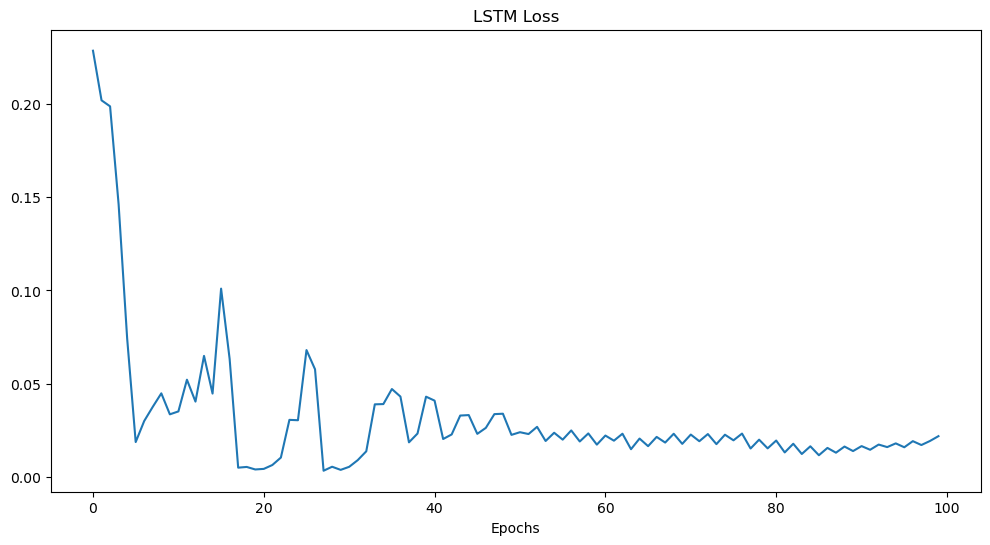

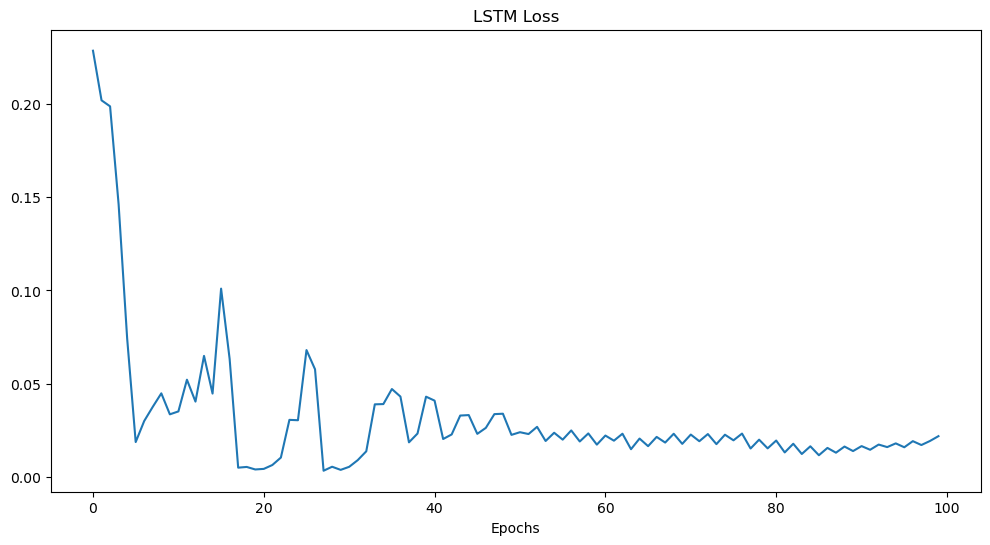

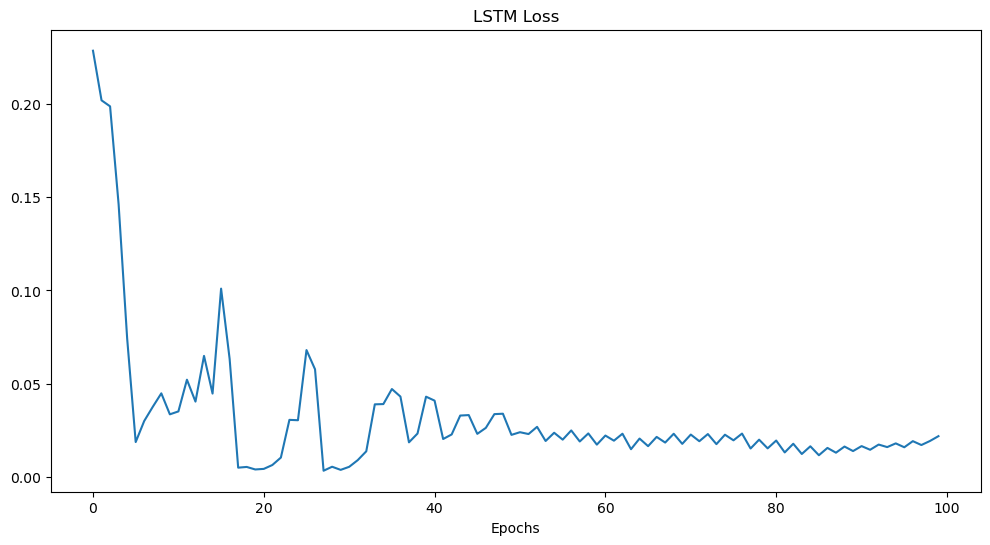

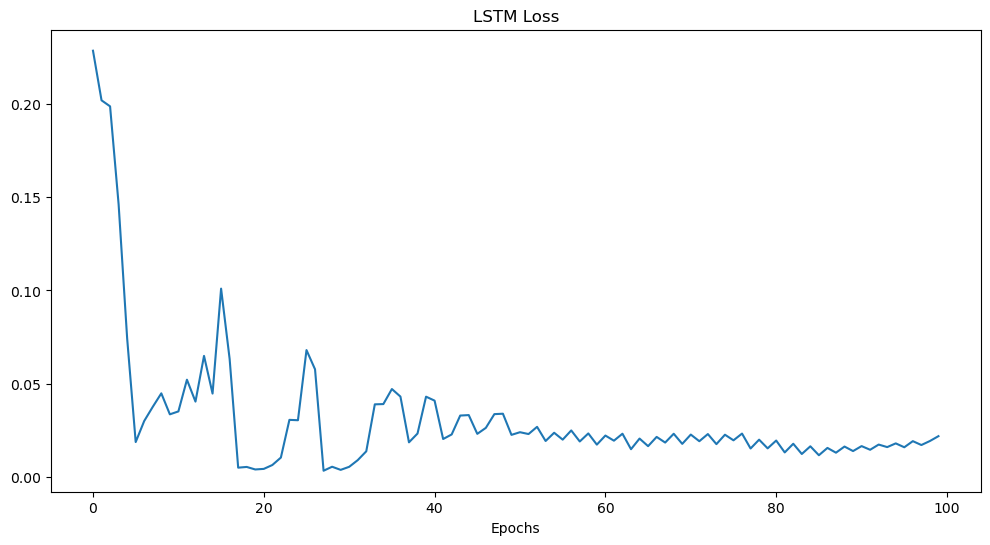

In [67]:
batch_size_options = [64, 128, 256]
learning_rate_options = [0.001, 0.0001, 0.00001]
num_epochs_options = [50, 100]



num_trials = 14  # Number of trials in the random search
best_rmse = float('inf')
best_params = {}

for trial in range(num_trials):
    batch_size = int(np.random.choice(batch_size_options))
    learning_rate = float(np.random.choice(learning_rate_options))
    num_epochs = int(np.random.choice(num_epochs_options))
    input_size = 35
    print(f'num trial: {trial}, batch_size: {batch_size}, learning_rate: {learning_rate}, num_epochs: {num_epochs}')


    # Initialize the LSTM trainer with the randomly selected hyperparameters
    lstm_trainer = LSTMTraining(input_size, batch_size, learning_rate, num_epochs)

    lstm_trainer.train(train_x_slide, train_y_slide)
    lstm_trainer.model.eval()

    plt.figure(figsize = (12, 6))
    plt.plot(history, label = 'Loss')
    plt.title('LSTM Loss')
    plt.xlabel('Epochs')

    pred_y_validation = lstm_trainer.model(validation_x_slide.to(lstm_trainer.device))

    rescaled_y_validation = y_scaler.inverse_transform(validation_y_slide)
    rescaled_pred_y_validation = y_scaler.inverse_transform(pred_y_validation.detach().numpy())

    MSE_validation = mean_squared_error(rescaled_y_validation, rescaled_pred_y_validation)
    rmse = math.sqrt(MSE_validation)

    if rmse < best_rmse:
        best_rmse = rmse
        best_params = {'batch_size': batch_size, 'learning_rate': learning_rate, 'num_epochs': num_epochs}

print(f"Best Parameters: {best_params}")
print(f"Best RMSE: {best_rmse}")


In [68]:
input_size =35
batch_size= 256
learning_rate = 0.0001
num_epochs =50
lstm_trainer = LSTMTraining(input_size, batch_size, learning_rate, num_epochs)
history = lstm_trainer.train(train_x_slide, train_y_slide)

[1/50] Loss: 0.5007175635546446
[2/50] Loss: 0.3192655583843589
[3/50] Loss: 0.15116147696971893
[4/50] Loss: 0.024540580838220194
[5/50] Loss: 0.05038370651891455
[6/50] Loss: 0.054245824547251686
[7/50] Loss: 0.039309652463998646
[8/50] Loss: 0.028578273486346006
[9/50] Loss: 0.02505440666573122
[10/50] Loss: 0.025011620367877185
[11/50] Loss: 0.021953670104267076
[12/50] Loss: 0.01619444796233438
[13/50] Loss: 0.012886129057733342
[14/50] Loss: 0.009925568039761856
[15/50] Loss: 0.007613858469994739
[16/50] Loss: 0.005211985437199473
[17/50] Loss: 0.003716120816534385
[18/50] Loss: 0.0028146855911472812
[19/50] Loss: 0.002006260350754019
[20/50] Loss: 0.002056783858279232
[21/50] Loss: 0.0018784023777698167
[22/50] Loss: 0.0021054600802017376
[23/50] Loss: 0.0018267457126057707
[24/50] Loss: 0.002072383140330203
[25/50] Loss: 0.0019290656637167558
[26/50] Loss: 0.0021707279956899583
[27/50] Loss: 0.0020175160898361355
[28/50] Loss: 0.0020938969501003157
[29/50] Loss: 0.0016669320175

Text(0.5, 0, 'Epochs')

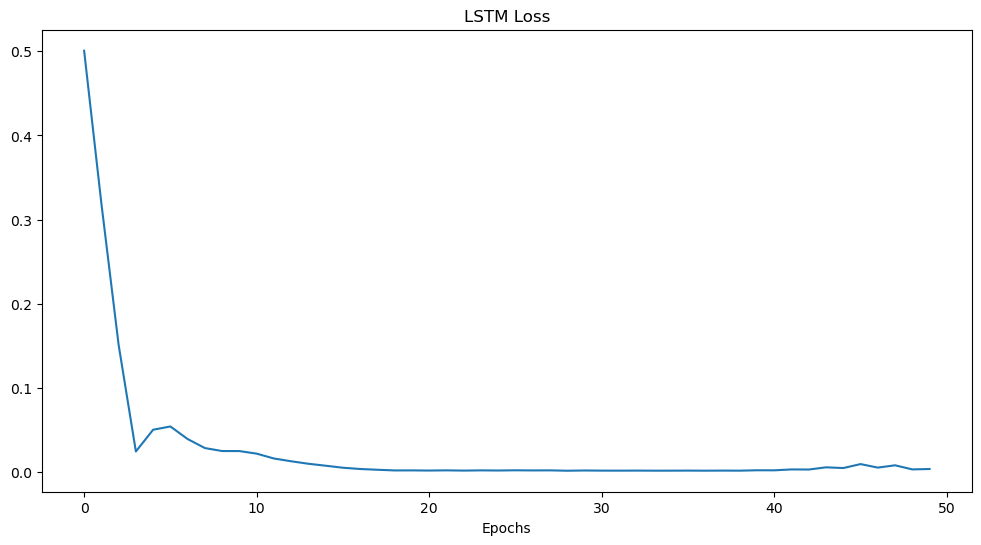

In [69]:
plt.figure(figsize = (12, 6))
plt.plot(history, label = 'Loss')
plt.title('LSTM Loss')
plt.xlabel('Epochs')

In [70]:
lstm_trainer.model.eval()
pred_y_train = lstm_trainer.model(train_x_slide)
pred_y_test = lstm_trainer.model(test_x_slide)

y_train = train_y_slide
y_test = test_y_slide


In [71]:
import pickle

# Load the saved scaler
y_scaler = pickle.load(open('./Downloads/target_scaler.pkl', 'rb'))

# Use the loaded scaler to inverse transform the data
rescaled_y_train = y_scaler.inverse_transform(y_train)
rescaled_y_test = y_scaler.inverse_transform(y_test)


rescaled_pred_y_train = y_scaler.inverse_transform(pred_y_train.detach().numpy())
rescaled_pred_y_test = y_scaler.inverse_transform(pred_y_test.detach().numpy())

/opt/anaconda3/lib/python3.10/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Training dataset RMSE:1.71976211862597
Train dataset MAPE:0.05371620900165025
Train dataset MAE:1.3292799219780822


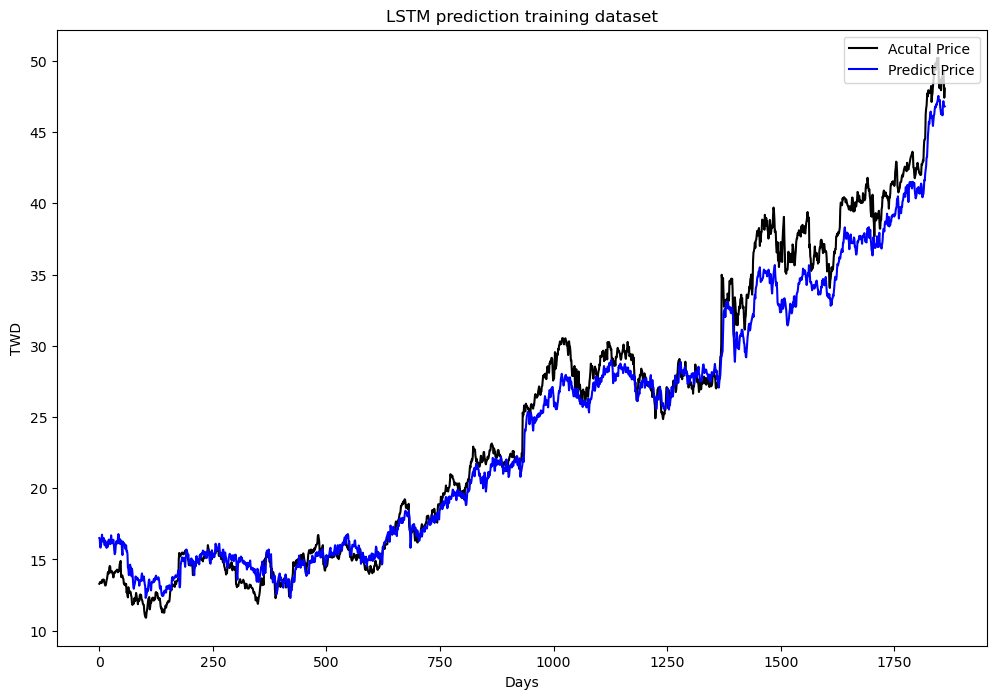

In [72]:
plt.figure(figsize=(12, 8))
plt.plot(rescaled_y_train, color = 'black', label = 'Acutal Price')
plt.plot(rescaled_pred_y_train, color = 'blue', label = 'Predict Price')
plt.title('LSTM prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(rescaled_y_train, rescaled_pred_y_train)
RMSE = math.sqrt(MSE)
MAPE = mean_absolute_percentage_error(rescaled_y_train, rescaled_pred_y_train)
MAE = mean_absolute_error(rescaled_y_train, rescaled_pred_y_train)
print(f'Training dataset RMSE:{RMSE}')
print(f'Train dataset MAPE:{MAPE}')
print(f'Train dataset MAE:{MAE}')

Training dataset RMSE:4.378147211981538
Train dataset MAPE:0.05514040978807622
Train dataset MAE:3.602760409727607


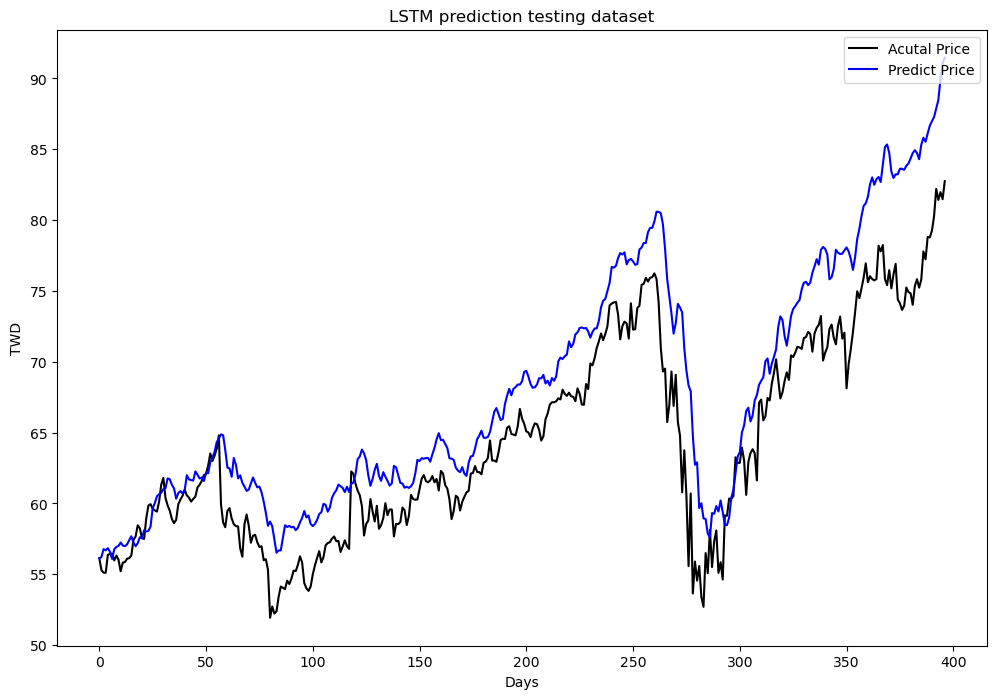

In [73]:
plt.figure(figsize=(12, 8))
plt.plot(rescaled_y_test, color = 'black', label = 'Acutal Price')
plt.plot(rescaled_pred_y_test, color = 'blue', label = 'Predict Price')
plt.title('LSTM prediction testing dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(rescaled_y_test, rescaled_pred_y_test)
RMSE = math.sqrt(MSE)
MAPE = mean_absolute_percentage_error(rescaled_y_test, rescaled_pred_y_test)
MAE = mean_absolute_error(rescaled_y_test, rescaled_pred_y_test)
print(f'Training dataset RMSE:{RMSE}')
print(f'Train dataset MAPE:{MAPE}')
print(f'Train dataset MAE:{MAE}')

##Subsampling

In [74]:

y_test = test_y_slide

subsample_rmses = []


# Iterate over the test set in windows of 50 days
for start in range(0, len(test_x_slide), 50):
    end = start + 50
    # If the last window has less than 50 days, we take whatever is remaining
    if end > len(test_x_slide):
        end = len(test_x_slide)

    # Slice the test set to get a subsample
    subsample_x = test_x_slide[start:end]
    subsample_y = y_test[start:end]

    # Make predictions on the subsample
    pred_y_subsample = lstm_trainer.model(subsample_x)

    # Use the loaded scaler to inverse transform the data

    rescaled_y_test = y_scaler.inverse_transform(subsample_y)

    rescaled_pred_y_test = y_scaler.inverse_transform(pred_y_subsample.detach().numpy())

    MSE = mean_squared_error(rescaled_y_test, rescaled_pred_y_test)
    RMSE = math.sqrt(MSE)
    subsample_rmses.append(RMSE)


print(f'Subsample RMSE: {subsample_rmses}')


Subsample RMSE: [1.1671091993088367, 3.8205865601060056, 3.0736295078626177, 2.455784253366192, 3.441293301191874, 5.977132693017715, 4.164756211261649, 7.707717298430395]


In [75]:
df = pd.DataFrame(subsample_rmses, columns=['RMSE'])


df.to_csv('./Downloads/LSTMsubsample_rmses.csv', index=False)
